In [1]:
!pip install datasets transformers torch wandb

In [2]:
from datasets import load_dataset, load_metric
from dataclasses import dataclass
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, set_seed
import numpy as np
from torch.utils.data import DataLoader
import numpy as np

import wandb
wandb.login()
%env WANDB_PROJECT=subset_active_learning

wandb: Currently logged in as: garylai. Use `wandb login --relogin` to force relogin


env: WANDB_PROJECT=subset_active_learning


In [3]:
@dataclass(frozen=True)
class Config:
    max_length: int = 66
    debug: bool = False
    model_name: str = "google/electra-small-discriminator"
    strategy: str = "random_sampling"
    sampling_size: int = 1000
    max_steps: int = 10000


config = Config(max_length=66, debug=False, strategy="random_sampling", sampling_size=1000, max_steps=10000)
dir = f"/content/drive/MyDrive/active_learning/{config.strategy}/size_{config.sampling_size}"
!mkdir $dir

mkdir: cannot create directory ‘/content/drive/MyDrive/active_learning/random_sampling/size_1000’: File exists


# Data

In [4]:
tokenizer = AutoTokenizer.from_pretrained("google/electra-small-discriminator")
metric = load_metric("accuracy")

def preprocess(data):
    data = data.rename_column('label', 'scalar_label')
    data = data.map(lambda x: {'label' : 0 if x['scalar_label'] < 0.5 else 1})

    def tokenize_func(examples): 
        tokenized = tokenizer(
            examples["sentence"], padding="max_length", max_length=config.max_length, truncation=True
        )
        tokenized["labels"] = examples["label"]
        return tokenized

    ds = data.map(
        tokenize_func,
        remove_columns=data.column_names,
        batched=True,
    )
    ds.set_format(type="torch")
    return ds

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [5]:
set_seed(42)

sst2 = load_dataset("sst")

if config.strategy == "random_sampling":
  print(f"config strategy is {config.strategy}")
  selected_indices = np.random.choice(len(sst2["train"]), replace=False, size=1000)
  selected_data = sst2["train"].select(selected_indices)
  debug_data = sst2["train"].select(selected_indices[:8])

train_ds = preprocess(selected_data)
valid_ds = preprocess(sst2["validation"])
test_ds = preprocess(sst2["test"])
debug_ds = preprocess(debug_data)

No config specified, defaulting to: sst/default
Reusing dataset sst (/root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff)


  0%|          | 0/3 [00:00<?, ?it/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-081c89afd87b15bb.arrow


config strategy is random_sampling


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-ce39997f8c4d62b8.arrow


  0%|          | 0/2 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-c490c4f1acb5329d.arrow


  0%|          | 0/3 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/sst/default/1.0.0/b8a7889ef01c5d3ae8c379b84cc4080f8aad3ac2bc538701cbe0ac6416fb76ff/cache-7dc9b7dd397a1836.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

In [6]:
list(map(len, [train_ds, valid_ds, test_ds, debug_ds]))


[1000, 1101, 2210, 8]

# Training

In [7]:
training_args = TrainingArguments(output_dir=dir, 
                                  max_steps=config.max_steps, 
                                  evaluation_strategy="steps", 
                                  eval_steps=config.max_steps//10, 
                                  report_to="wandb", 
                                  run_name=f"{config.strategy}-size-{config.sampling_size}")

In [8]:
training_args.max_steps

10000

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(config.model_name, num_labels=2)

Some weights of the model checkpoint at google/electra-small-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier

In [10]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds if not config.debug else debug_ds,
    eval_dataset=valid_ds if not config.debug else debug_ds,
    compute_metrics=compute_metrics,
)

max_steps is given, it will override any value given in num_train_epochs


In [ ]:
trainer.train()
wandb.finish()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 1000
  Num Epochs = 80
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 10000
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss,Accuracy
1000,0.071500,1.494950,0.775658
2000,0.023100,1.799206,0.775658
3000,0.006100,1.807113,0.786558


Saving model checkpoint to /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-500
Configuration saved in /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-500/config.json
Model weights saved in /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-500/pytorch_model.bin
***** Running Evaluation *****
  Num examples = 1101
  Batch size = 8
Saving model checkpoint to /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-1000
Configuration saved in /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-1000/config.json
Model weights saved in /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-1500
Configuration saved in /content/drive/MyDrive/active_learning/random_sampling/size_1000/checkpoint-1500/config.json
Model weights sav

In [2]:
# testing code

import pickle

test_set_results = []

for training_size in (1000, 3000, 5000, 7000):
    with open(f"./test_set_results/test_set_evaluation_{training_size}.pkl", "rb") as f:
        test_set_result = pickle.load(f)
        test_set_results.append(test_set_result)

In [3]:
test_accs = list(map(lambda x: x.metrics["test_accuracy"], test_set_results))

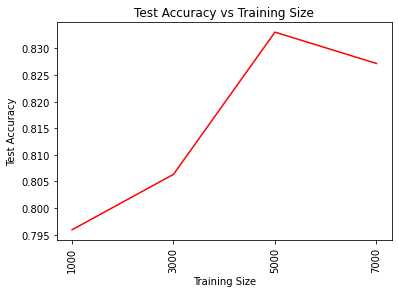

In [4]:
import matplotlib.pyplot as plt
# plot a scatter plot, set the x axis to 1000, 3000, 5000
x = range(len(test_accs))
y = test_accs

plt.plot(x, y, 'r')
plt.xticks(x, [(i*2+1)*1000 for i, _ in enumerate(test_accs)], rotation='vertical')
plt.xlabel("Training Size")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Training Size")
plt.show()